# Introduction to text analysis IX #

### text clustering ###

In [1]:
import pickle
import string
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
stops_it = stopwords.words('italian')
stops_en = stopwords.words('english')

translator = str.maketrans(' ', ' ', string.punctuation) ## remove the punctuation

In [6]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data
print(len(docs_raw))

11314


** save the data for future use **

In [7]:
pickle.dump(docs_raw,open("20news.pickle","wb"))

** functions for text treatment **

In [8]:
def minimumSize(tokens,llen = 2):
    ## remove words smaller than llen chars
    tks = []
    for t in tokens:
        if(len(t) > llen):
            tks.append(t)
    return tks

def removeStops(tokens,stops = stops_it):
    # remove stop words
    remains = []
    for t in tokens:
        if(t not in stops):
            remains.append(t)
    return remains

def processText(text):
    ## tokenizer with stop words removal and minimum size 
    tks = word_tokenize(text)
    tks = [t.translate(translator) for t in tks] ## remove the punctuation
    tks = minimumSize(tks)
    tks = removeStops(tks,stops_en)
    return tks

In [9]:
n_features = 1000 
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,tokenizer=processText)

In [10]:
corpus = docs_raw[0:1000]


In [11]:

#tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf = tfidf_vectorizer.fit_transform(corpus)

** from the tfdif to the similarity of the documents **

In [26]:
pairwise_similarity = tfidf * tfidf.T ## scalar product

In [27]:
pairwise_similarity

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 514087 stored elements in Compressed Sparse Row format>

In [29]:
XD = pairwise_similarity.todense() #sparce to dense i.e empty to 0

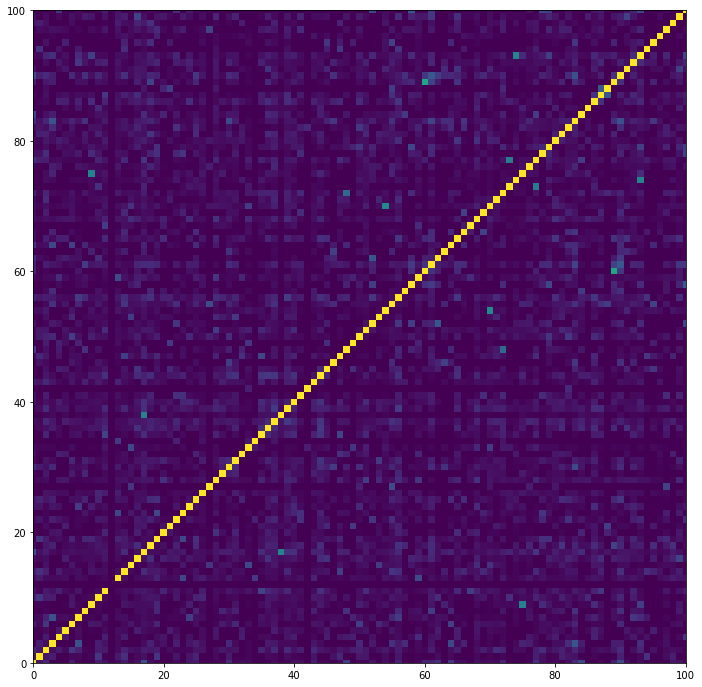

In [32]:
plt.figure(figsize=(12,12))
plt.xlim(0,100)
plt.ylim(0,100)
plt.imshow(XD) 
# we can see a semetric matrix in the figure (mirror image)

In [35]:
from sklearn.preprocessing import Normalizer 
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans #KMean is used for clustering

In [36]:
true_k = 20

In [37]:
nn = Normalizer()
XN = nn.fit_transform(XD)

In [38]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,verbose=True)

In [39]:
km.fit(XN)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 651.339828565
start iteration
done sorting
end inner loop
Iteration 1, inertia 629.760568436
start iteration
done sorting
end inner loop
Iteration 2, inertia 623.685924718
start iteration
done sorting
end inner loop
Iteration 3, inertia 620.43200858
start iteration
done sorting
end inner loop
Iteration 4, inertia 618.668265968
start iteration
done sorting
end inner loop
Iteration 5, inertia 617.881368586
start iteration
done sorting
end inner loop
Iteration 6, inertia 617.505775602
start iteration
done sorting
end inner loop
Iteration 7, inertia 617.368813212
start iteration
done sorting
end inner loop
Iteration 8, inertia 617.051661589
start iteration
done sorting
end inner loop
Iteration 9, inertia 616.65727122
start iteration
done sorting
end inner loop
Iteration 10, inertia 616.209452003
start iteration
done sorting
end inner loop
Iteration 11, inertia 615.935700053
start iteration
done sorting

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [40]:
tws = list(corpus) 
clusters = {}
idx = 0
for t in km.labels_:
    if(t in clusters):
        clusters[t].append(tws[idx])
    else:
        clusters[t]= [tws[idx]]
    idx += 1

In [41]:
for k,v in clusters.items():
    print(k,len(v))

4 76
14 32
15 176
2 131
8 57
5 94
16 30
12 45
3 192
11 25
9 33
13 10
19 21
6 32
7 13
10 16
1 12
17 1
0 2
18 2


In [43]:
for c in clusters[9]:
    print(c)
    print("########")


I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 
########

Funny you should mention this; one time on HNIC Don Cherry pointed out
Vanbiesbrouck's mask.  He _hated_ it.  I think he said something to the effect
of:
"You see?  He was great last year; now he goes out and gets that dopey mask 
and he can't stop a beachball!"

You may or may not take Cherry seriously at all, but I cracked up when I heard
it.
########




Easy Rider (harleys, drugs, rednecks, New Orleans), Mad Max (violence, DoD 
wanna-be's), Time Rider (Honda Thumper, Time travel), On 

### how to get the optimal number of clusters ###

** the Elbow method **

In [44]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

In [45]:
scores = []
distortions = []
rng = range(2,30,1)
for t in rng:
    km = KMeans(n_clusters=t, init='k-means++', max_iter=100, n_init=1,verbose=False)
    km.fit(XD)

    distortions.append( km.inertia_ )
    if(t%10 == 0):
        print(t)

10
20


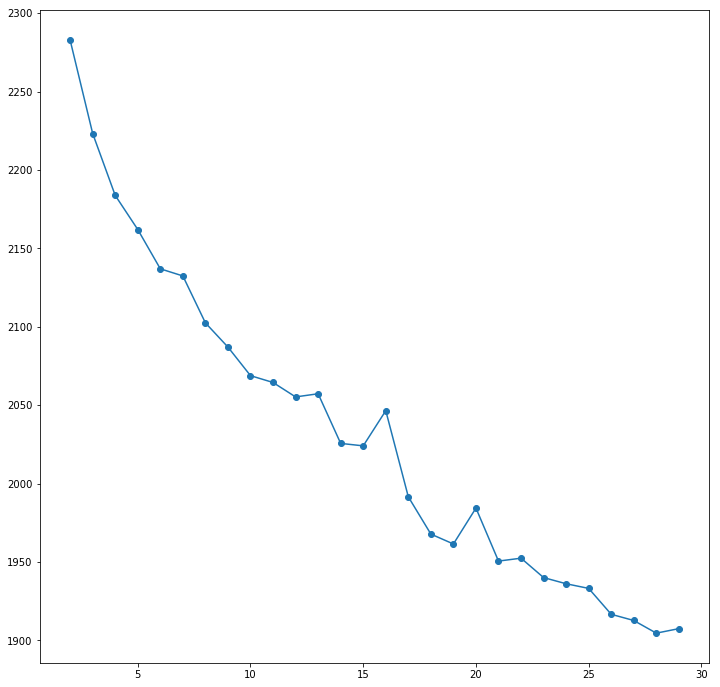

In [47]:
plt.figure(figsize=(12,12))
plt.plot( rng,distortions,marker="o") #the line is beding as an elbow (as pe the thmb rule), 
#we can count that and change the number of clusters

** considerations **

Ideally the plot it will show a point where the slope changes, the point where there is a change is the "elbow" and this is the optimal point (if any) 